In [1]:
import sys

# setting path
sys.path.append('../')
import TestFunctions as tf
import EvaluationTracker as et
#import TestFunctions as tf
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from importlib import reload
import random
import time
import matplotlib.animation as animation
import math

In [2]:
class Solution:
    def __init__(self, dimension, lower_bound, upper_bound):
        self.d = dimension
        self.lower = lower_bound # we will use the same bounds for all parameters
        self.upper = upper_bound
        self.params = np.zeros(self.d) #solution parameters
        self.f = np.inf # objective function evaluation

In [6]:
def generatePopulation(solution : Solution, size):
    population = []
    for _ in range(0, size):
        new_solution = Solution(len(solution.params), solution.lower, solution.upper) # Generate solution
        for i in range(0, len(solution.params)): 
            new_solution.params[i] = random.uniform(solution.lower, solution.upper) # Generate its params
            #print(new_solution.params)
        population.append(new_solution)
    return population

# Evaluate entire population on function func
def evaluateAll(population, func, evaluationTracker : et.EvaluationTracker):
    for solution in population:
        z = func(solution.params)
        evaluationTracker.currentEvalCount += 1
        solution.f = z
    return population

def pickBest(population):
    bestScore = 40000
    bestSolution = None
    for solution in population:
        if solution.f < bestScore:
            bestScore = solution.f
            bestSolution = solution
    return bestSolution

def generateVectors(population, v_min = -1, v_max = 1):
    vectors = []
    for solution in population:
        vector = []
        for i in range(0, len(solution.params)):
            vector.append(random.uniform(v_min,v_max)) # Vectors parameters will have values from -1 to 1
        vectors.append(vector)
    return vectors

def updateVector(solution : Solution, bestPSolution : Solution, bestGSolution : Solution, vector, index, M_max):
    w_s = 0.9
    w_e = 0.4
    c1, c2 = 2, 2
    w = w_s - ((w_s - w_e) * index/M_max)
    r1 = np.random.uniform()
    newVector = []
    for i in range(0, len(solution.params)):
        newParam = (vector[i] * w) + (r1 * c1 * (bestPSolution.params[i] - solution.params[i])) +  r1 * c2 * (bestGSolution.params[i] - solution.params[i])
        newVector.append(newParam)
    return newVector

def updatePosition(solution : Solution, vector):
    new_population = Solution(len(solution.params), solution.lower, solution.upper)
    for i in range(0, len(solution.params)):
        new_population.params[i] = solution.params[i] + vector[i]
    return new_population

def ParticleSwarm(solution, func):
    for i in range(0,len(solution.params)):
        solution.params[i] = random.uniform(solution.lower, solution.upper) # Generate random coordinates for the first time
    evaluationTracker = et.EvaluationTracker()
    pop_size = 15
    v_min, v_max = -1, 1
    population = generatePopulation(solution, pop_size) # Get population
    population = evaluateAll(population, func, evaluationTracker) # Set evaluations for population
    gBest = pickBest(population) # Best Global population
    vectors = generateVectors(population=population, v_min=v_min, v_max=v_max) # velocities for populations
    bestPopulation = list(np.copy(population)) # At first best versions of populations are the same as initial populations
    M_max = 50
    m = 0
    progressTracker = []
    while m < M_max :
        for i in range(0, len(population)):
            vectors[i] = updateVector(solution=population[i], bestPSolution = bestPopulation[i], bestGSolution=gBest, vector=vectors[i], index=i, M_max=M_max) # Update current velocity
            vectors[i] = np.clip(vectors[i], v_min, v_max) # Check boundaries
            population[i] = updatePosition(population[i], vectors[i]) # Update position (Generates new Solution)
            population[i].params = np.clip(population[i].params, population[i].lower, population[i].upper) # Check boundaries
            population[i].f = func(population[i].params) # Update population's evaluation
            evaluationTracker.currentEvalCount += 1
            if evaluationTracker.currentEvalCount > evaluationTracker.maxEval:
                return progressTracker
            #Compare a new position of a particle x to its pBest
            if population[i].f < bestPopulation[i].f:
                bestPopulation[i] = population[i]
                if population[i].f < gBest.f:
                    gBest = population[i]
                    progressTracker.append((population[i].params.copy()[0], population[i].params.copy()[1], population[i].f))
        m += 1
    return progressTracker

In [4]:
def plot3DWithAnimation(xRangeMin, xRangeMax, yRangeMin, yRangeMax, func, params, gifName):
    x = np.linspace(xRangeMin, xRangeMax, 30)
    y = np.linspace(yRangeMin, yRangeMax, 30)
    #x = np.concatenate((x[x<0], [0], x[x>0]))#insert [0,0], doesnt work neither
    #y = np.concatenate((y[y<0], [0], y[y>0]))
    X, Y = np.meshgrid(x, y)
    Z = func((X, Y))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='magma', edgecolor='none', zorder=1, alpha=0.4)
    ax.set_title(func.__name__)
    ax.set_zlim(0, Z.max())
    scatter = ax.scatter([], [], [], color='red', s=100, zorder=4)  # Placeholder for the scatter plot
    # Function thats gonna be called by FuncAnimation at every interval
    def animate(i):
        x = [params[i][0]]  
        y = [params[i][1]]  
        z = [params[i][2]]
        scatter._offsets3d = (x, y, z)  # Update the scatter plot data
        #plt.pause(0.2) # Pause plotting for smoother animation
    ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(params), interval=1000) # Generate animation
    
    writer = animation.PillowWriter(fps=1, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(gifName, writer=writer) # Save animation -> plt.show() of Gif seems to display just one frame in Jupyter notebook, viewing gif file seperately shows entire animation
    
    plt.show()

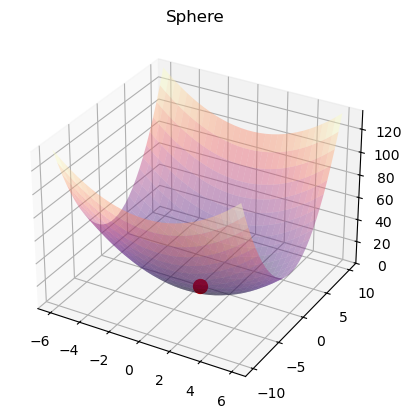

In [7]:
funcs = tf.getAllFunctions()
x = Solution(2,funcs[0][1],funcs[0][0])
func = funcs[0][4]
result = ParticleSwarm(x,func)
func = funcs[0]
params = result
plot3DWithAnimation(func[0],func[1],func[2],func[3],func[4],params,'SpherePartialSwarm.gif')

In [8]:
result

[(1.6239417186729987, -1.724234153383292, 5.61017012134001),
 (-1.9014951071395387, 0.9045152343734255, 4.433831451689219),
 (0.9572674315458105, 0.4937810299736114, 1.1601806410601134),
 (0.6239417186729987, -0.7242341533832919, 0.9138183772274291),
 (-0.9014951071395387, -0.09548476562657449, 0.8218107686632903),
 (0.000773489267899885, -0.37632014055445195, 0.14161744647257002),
 (-0.17324875342476487, -0.10030049029477572, 0.04007531891660737),
 (0.05365548831614875, 0.14453348058390159, 0.023768838436141432),
 (-0.09650088138596141, 0.03367953788504674, 0.010446731380417691),
 (-0.06694244755684298, 0.023935544710909973, 0.005054201585508643),
 (0.006621166196568384, -0.023249880727172156, 0.0005843967956303111),
 (0.0092503711733109, -0.021090235241099986, 0.0005303673893689571),
 (0.020709626154075858, -0.003978776152963211, 0.00044471927511697157),
 (0.018013489790261267, -0.008077741293878104, 0.0003897357188346704),
 (0.015964426153762177, -0.011192954800973421, 0.00038014513

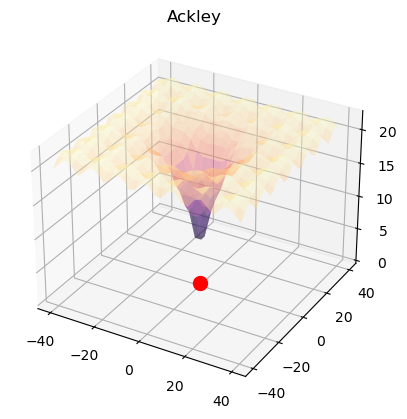

In [22]:
funcs = tf.getAllFunctions()
x = Solution(2,funcs[1][1],funcs[1][0])
func = funcs[1][4]
result = ParticleSwarm(x,func)
func = funcs[1]
params = result
plot3DWithAnimation(func[0],func[1],func[2],func[3],func[4],params,'AckleyPartialSwarm.gif')

In [23]:
result

[(8.64367167058412, -7.771111663275919, 18.069586331220705),
 (7.79367167058412, -7.326461106213199, 17.403314684042517),
 (7.071171670584119, -6.948508132709888, 15.27470440051995),
 (-2.480625773316813, -6.790106532960404, 14.833637197575491),
 (0.543140485473657, -6.440917110054508, 14.31322870837399),
 (-0.326859514526343, -5.570917110054508, 13.129220028279548),
 (-1.083759514526343, -4.814017110054508, 10.891132186221293),
 (-1.742262514526343, -4.155514110054508, 10.852306892055209),
 (-2.056162289716508, -3.6641186905614873, 10.441673321161225),
 (1.635953936636855, -2.763583583133661, 9.267419670041956),
 (-2.0294291519338197, -2.6873503689920812, 8.946593399867155),
 (0.635953936636855, -2.177930006110971, 7.311751876675816),
 (-1.0294291519338197, -1.6873503689920812, 6.246059576886282),
 (-0.36404606336314504, -1.4425638172961381, 6.062124492517626),
 (-0.029429151933819675, -0.7832441102418031, 3.0034254418026802),
 (0.21637529603896832, -0.013575466509432976, 1.4945276516